# Beispiel 2

Antonia Magenheim (Mat.Nr.: 11711025)  
Kayran Schmidt (Mat.Nr.: 01604789)

In [1]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.constants as const
from scipy.optimize import curve_fit


As a first step all csv data was loaded into some numpy arrays and collected in a standard list.  
The MaskedArray NumPy array was chosen, because it will make it easier later, to fnid the Na absorption features.

In [2]:
# get the data

data = list()

for i in range(1,12,1):
    tmp = np.loadtxt(f"A2_daten_csv/{i}.csv", delimiter=",", skiprows=1)
    d = np.ma.MaskedArray(tmp, mask=False)
    data.append(d)


As a next step the data was plotted and compared to the results from ImageJ in order to ensure that the data was correctly imported.

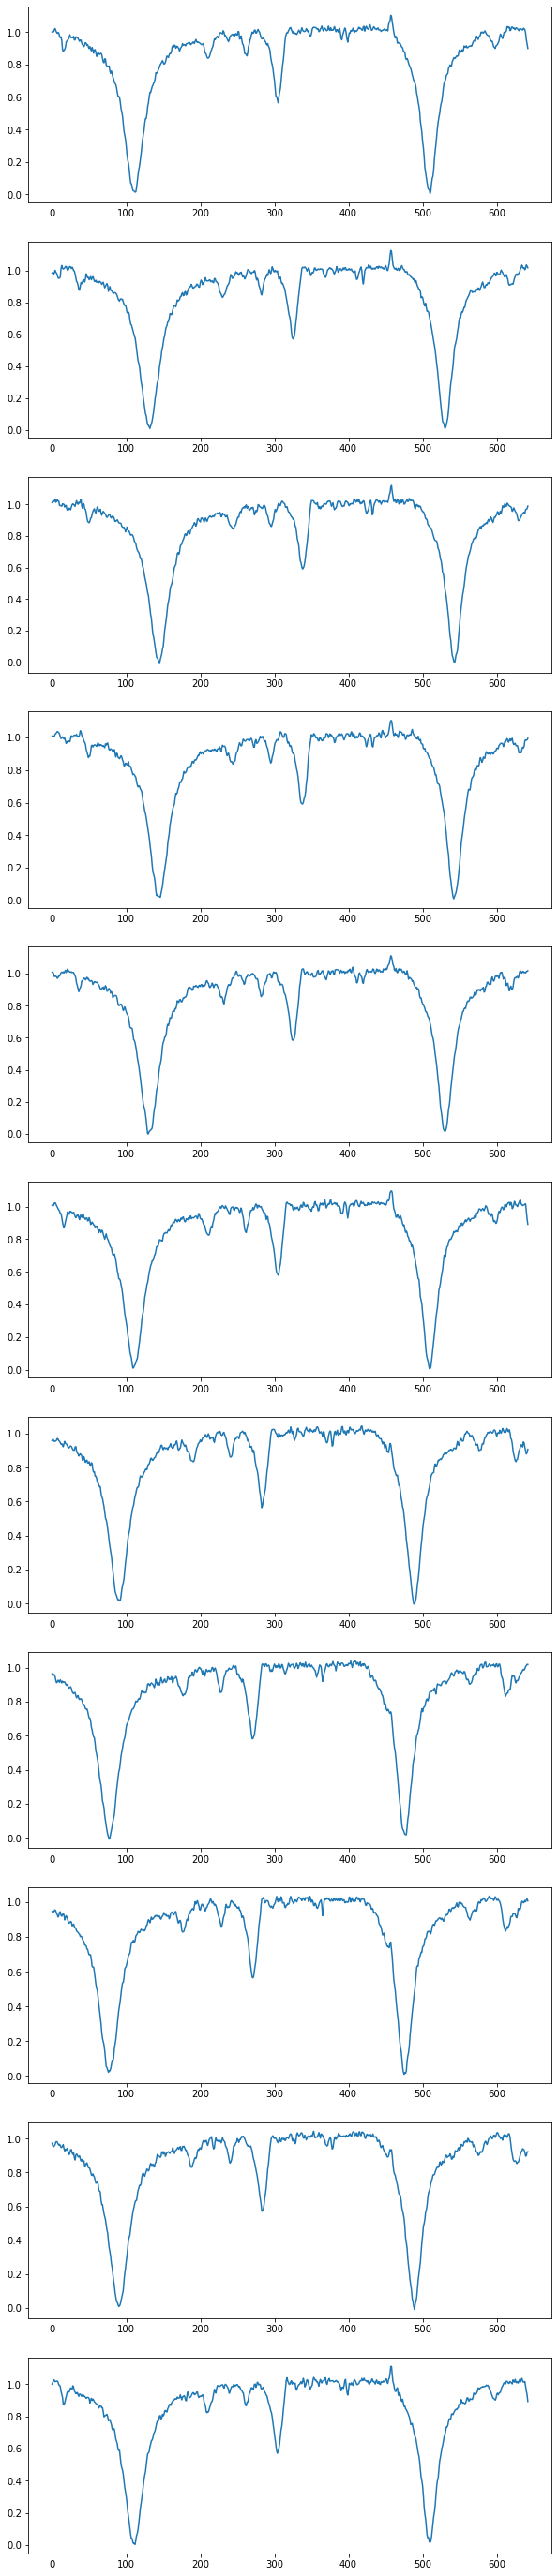

In [3]:
fig, ax = plt.subplots(11)
fig.set_size_inches(10,50)

for i, d in enumerate(data):
    ax[i].plot(d[:, 0], d[:, 1])

The next step is to identify the area of the Na absorption features. A Lorenztian fit will be used to model the spectra in these areas separately and the parameters of the fit will be used for determining the orbital parameters.
The Lorenztian is given as (see [WolframMathworld](https://mathworld.wolfram.com/LorentzianFunction.html)):  
$f(x)=a*\frac{\Gamma}{\Gamma^2 + (x - x_0)^2} + b$  
Where a is the scale factor, b is an offset from the 0 baseline, $x_0$ is the location of the maximum and $\Gamma$ is the $1/2$FWHM (full width half maximum).  

For isolating the absorption features a 1D "bubble search" has been applied. First the minimum of the pixel values is identified. Then an area with $\pm70$px around this minimum wil be flagged in the array mask and the boundary pixels of this are are stored. When repeating this procedure for the second absorption feature, the masked array elements are no longer taken into account for finding the minimum so that the second minimum will be correctly identified.  
The refernece pixel was identified following the same method, but searching for the maximum in a very narrow pixel range: $457\pm5$. The initial value of 457 was guessed based upon the first spectrum. This method required to manually fix the reference pixel location for the 8th plot, as here there is no clear paek visible for the reference pixel and the reference value of 457 was taken.

The fits for the Lorenztians are calculated using the "curve_fit" function from scipy.optimize. Here it is necessary to supply good approximations for the fitting parameters or else the fitting algorithm will not converge.

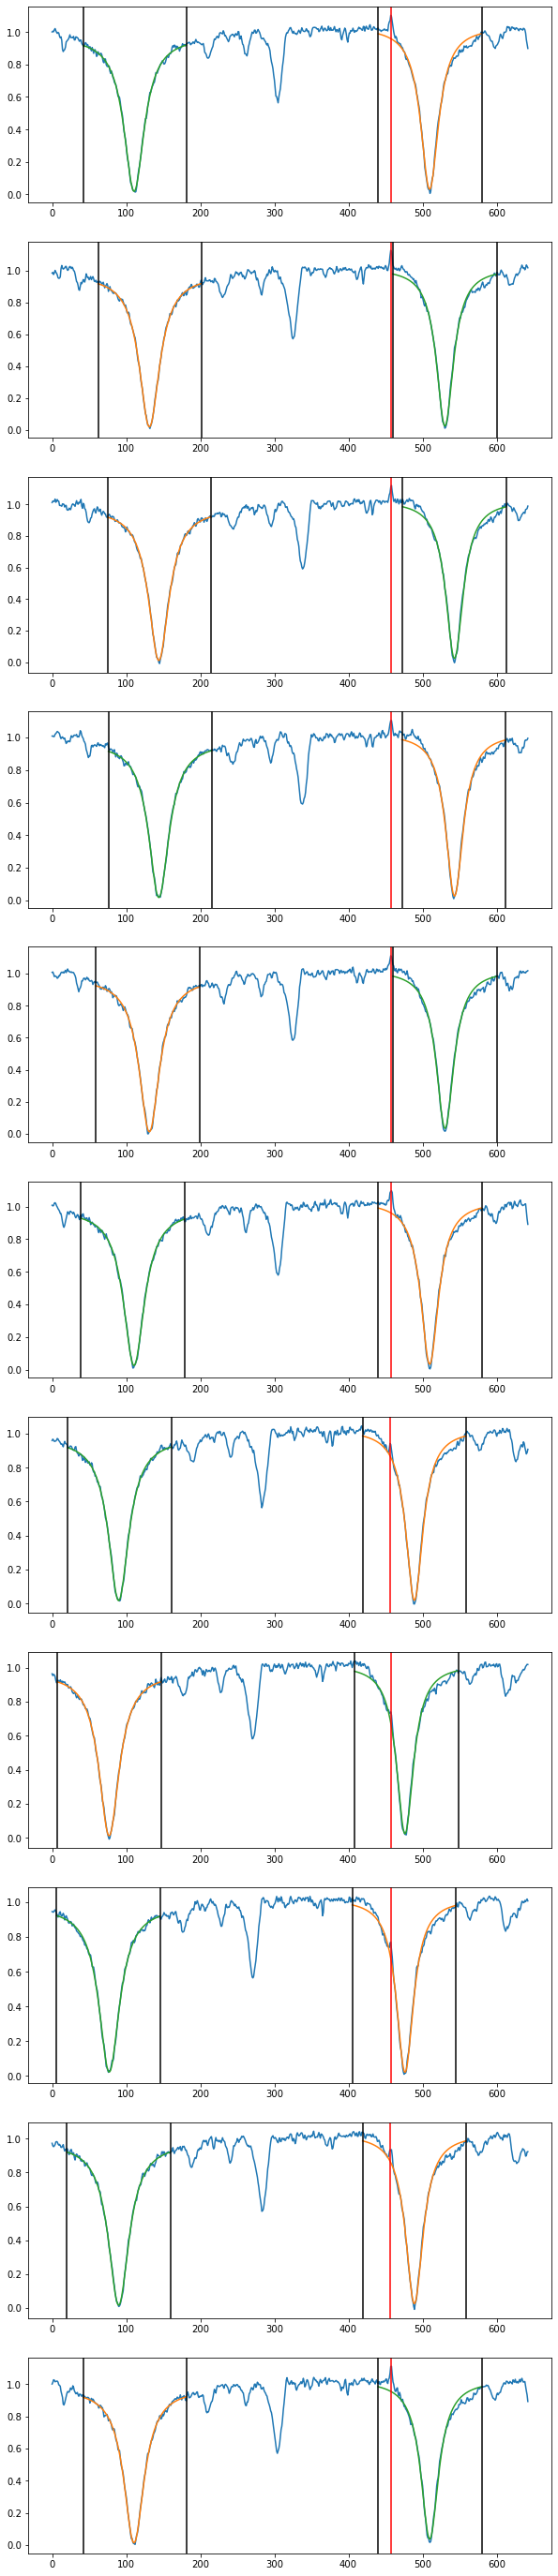

In [4]:

# x0 == max, gam == 1/2 FWHM, a == norm, b == offset
def lorentzian(x, x0, a, gam, b):
    return a * gam / ( gam**2 + ( x - x0 )**2) + b

fig, ax = plt.subplots(11)
fig.set_size_inches(10,50)

##### DATA #####
referencePixelPos = list()
NaPixelPos = list()

for i, dat in enumerate(data):
    # find both minimas and mark an aera with 140 px around them
    d = np.ma.copy(dat)
    arg = np.argmin(d[:,1])
    p1 = (arg-70, arg+70)
    d.mask[p1[0]:p1[1]] = True
    arg2 = np.argmin(d[:, 1])
    p2 = (arg2-70, arg2+70)
    d.mask[p2[0]:p2[1]] = True

    # plot spectra
    ax[i].plot(dat[:, 0], dat[:, 1])
    # invert mask to use the data
    d.mask = ~d.mask

    tempNaPos = list()
    # fit a lorentzian
    # plot and append params to array
    (x0, a, gam, b), _ = curve_fit(lorentzian, d[p1[0]:p1[1], 0], d[p1[0]:p1[1], 1], p0=(arg, -1, 1, 1))
    ax[i].plot(d[p1[0]:p1[1], 0], lorentzian(d[p1[0]:p1[1], 0], x0, a, gam, b))
    tempNaPos.append((x0, gam))

    (x0, a, gam, b), _ = curve_fit(lorentzian, d[p2[0]:p2[1], 0], d[p2[0]:p2[1], 1], p0=(arg2, -1, 1, 1))
    ax[i].plot(d[p2[0]:p2[1], 0], lorentzian(d[p2[0]:p2[1], 0], x0, a, gam, b))
    tempNaPos.append((x0, gam))

    # sort the positions, Na1 at first place, Na2 second
    tempNaPos.sort()
    # append to final list
    NaPixelPos.append(tempNaPos)
    # [ ...((x01,gam1),(x02,gam2)), ... ]

    # draw vertical lines for the region boundaries
    for x in p1+p2:
        ax[i].axvline(x, c="black")

    # for the reference pixel, take the maximum; eyeball 457 as center
    # 457 +- 5 bubble search again.
    r = (452, 462)
    p = np.argmax(dat[r[0]:r[1], 1]) + r[0]
    # fix the 8th plot, where there is no clear maximum in the bubble
    if i == 7:
        p = 457
    
    # append and plot
    referencePixelPos.append(p)
    ax[i].axvline(p, c="red")



The pixel values for the parameters are listed below. NaPixelPos contains for each time step the pixel values of the first Na lines center and its FWHM in the first tuple and the same for the second line in the second tuple. The pixel position for the reference line is in a separate list.

In [5]:
[print(x) for x in NaPixelPos]
print("\n", referencePixelPos)

[(110.65637731924416, 16.678564416431392), (509.47459088668694, 14.70875121180279)]
[(131.33847279222542, 16.83505100450328), (530.1274063523895, 14.066640926688402)]
[(143.96757961821137, 16.853872038447722), (542.9750529375117, 14.319396483742429)]
[(144.05245140472806, 16.770598033972067), (543.0041453696169, 14.32875522124647)]
[(131.22658091974458, 16.771171144499007), (530.2543244596018, 14.47545748586733)]
[(110.48342733201949, 17.277341362872964), (509.5529432914435, 14.622017943456704)]
[(89.78958849760063, 16.795762958708583), (488.8670162856349, 14.107736029915888)]
[(76.95677218505212, 16.677231609746567), (476.22423705723304, 13.957023251218255)]
[(77.10699559790362, 17.02568162644992), (476.2521769046448, 13.988004651026266)]
[(89.85990573117944, 16.966660339886698), (488.863664767422, 14.320921679140568)]
[(110.49436166123441, 16.66829062208999), (509.6462599849111, 14.580442917316216)]

 [457, 457, 458, 458, 457, 458, 456, 457, 457, 456, 458]


The next step is to calculate the linear velocity based on the doppler shift of the absorption features. Therefore we need the values for the restframe, wich are included in the fits header as well as the exercise description. The formula for calculating the linear velocity is given as:  
$\frac{\Delta\lambda}{\lambda}\times\text{c} = \Delta\text{v}$,
where c is the speed of light.  
In order to get the wavelength delta, the pixel count between the reference line and the center of the Na lines is calculated and converted to the wavelength value in angstroms based on the pixel scale of the spectrum. The this value is compared to the wavelength delta in the restframe which will yield the desired result. The timescale for the timeseries also needs to be calculated using the "TBTWOBS" key of the fits header, which gives the hours passed between to subsequent spectra.

In [6]:
##### DATA from the fits header #####
# angstroms
PixelRes = 0.015
refWLrestframe = 5895.05
# hours
TimeStep = 1.54

##### DATA for restframe #####
Na1 = 5889.95
Na2 = 5895.924
Na1RefDeltaRestframe = Na1-refWLrestframe
Na2RefDeltaRestframe = Na2-refWLrestframe

In [7]:
# WL diff to reference pixel in angstroms
NaRefDelta = [((n[0][0]-r)*PixelRes,(n[1][0]-r)*PixelRes) for n,r in zip(NaPixelPos, referencePixelPos)]
# WL diff to restframe in angstroms
NaDelta = [(n1 - Na1RefDeltaRestframe, n2 - Na2RefDeltaRestframe) for n1, n2 in NaRefDelta]
# lin vel in units of c (speed of light)
Na1VelDelta = [dl/Na1 for dl, _ in NaDelta]
Na2VelDelta = [dl/Na2 for _, dl in NaDelta]

# the timescale
times = [x*TimeStep for x in range(len(Na1VelDelta))]

For a quick check the resulting linear velocities are plotted. As expected the curves for both Na lines accurately match the same sinosiodal shape.

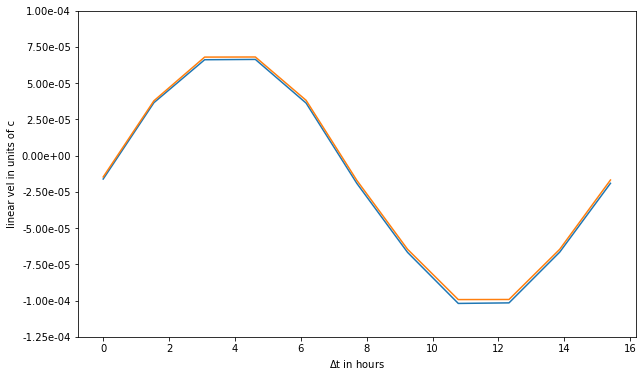

In [8]:
plt.figure(figsize=(10,6))
plt.plot(times, Na1VelDelta)
plt.plot(times, Na2VelDelta)
plt.xlabel(r"$\Delta$t in hours")
plt.ylabel("linear vel in units of c")
plt.yticks(plt.yticks()[0], [f"{l:1.2e}" for l in plt.yticks()[0]])
plt.show()


For fitting the sine waves again "curve_fit" was used. And again starting values for the fitting parameters have to be chosen or else the fit wil be very bad. In order to evaluate the fit, a scatter plot has been made. There are no patterns and the values are small and scattered randomly. All of which are signs for a good fit.

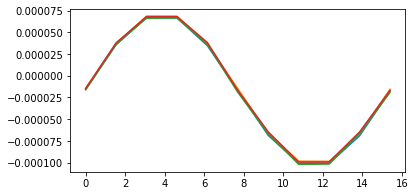

In [9]:
# the sinusiodal fit
# T == period, W == amplitude, lin speed in orbit

def vRad_cos(t, W, T, v0, b):
    return v0 + W*np.cos(2*np.pi * t/T + b)

# fits, NaFit = (W, T, v0, b)
Na1Fit, _ = curve_fit(vRad_cos, times, Na1VelDelta, p0=(1e-4, 8, 1, 0))
Na2Fit, _ = curve_fit(vRad_cos, times, Na2VelDelta, p0=(1e-4, 8, 1, 0))

# plot fits above curves
plt.figure(figsize=(6,3))
plt.plot(times, [vRad_cos(x, *Na1Fit) for x in times])
plt.plot(times, [vRad_cos(x, *Na2Fit) for x in times])
plt.plot(times, Na1VelDelta)
plt.plot(times, Na2VelDelta)
plt.show()

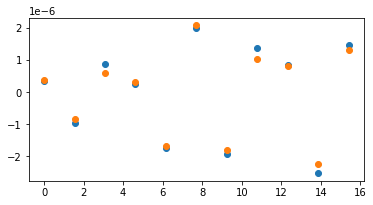

In [10]:
# plot residues
plt.figure(figsize=(6,3))
plt.scatter(times, [vRad_cos(x, *Na1Fit) - Na1VelDelta[i] for i, x in enumerate(times)])
plt.scatter(times, [vRad_cos(x, *Na2Fit) - Na2VelDelta[i] for i, x in enumerate(times)])
plt.show()

A very simple model for the binary system is as follows:  
Assuming a circular orbits the radius can be easily calculated using the orbital velocity and rotation period. Hereby using the fitted data from above for the primary star will give its distance to the center of mass:  
$r_1 = \frac{T v_1}{2\pi}$  
If the distance between the two stars is $a$ then:  
$a=r_1 + r_2$,   where $r_1, r_2$ are the distances of the primary and secondary star to the center of mass.    
By also using the relation:  
$M_1 r_1 = M_2 r_2$,   which follows from the definition of the center of mass.
and inserting it into the previous one yields:  
$r_2 = a \frac{M_1}{M_1 + M_2}$   
Now by substituting a from Keplers third law:   
$M_1 + M_2 = \frac{4\pi^2}{G} \frac{a^3}{T^3}$  
$r_2$ can be calculated as:  
$r_2 = \sqrt[\leftroot{-2}\uproot{2}3]{\frac{M_1^3 T^2 G}{(M_1 + M_2)^2 4\pi^2}}$ , where T is the fitted orbital period.  
Now by making the assumption $M_1 >> M_2$ this can be simplified:  
$r_2 = \sqrt[\leftroot{-2}\uproot{2}3]{\frac{M_1 T^2 G}{4\pi^2}}$  

The spectral type of the primary star noted in the fits header as: F0V. A typical $M_1$ for this type is around 1.2 solar masses (wikipedia).  
With $r_2$ known, the mass of the secondary star can be calculated:  
$\frac{M_1}{M_2}=\frac{r_2}{r_1}$  which follows from the definition of the center of mass.  
Also the linear radial velocity of the secondary star can be calculated now:  
$v_2 = \frac{r_2 2\pi}{T}$

Now all the requested parameters can be calculated. For each fit parameter, the avg over both fits will be used.

In [11]:
# W == V1
V1 = (np.abs(Na1Fit[0]) + np.abs(Na2Fit[0]))/2 * const.speed_of_light
T = (Na1Fit[1] + Na2Fit[1])/2 * 3600
V0 = (np.abs(Na1Fit[2]) + np.abs(Na2Fit[2]))/2 * const.speed_of_light

M1 = 1.2*1.9884e30

R1 = T * V1 / 2 / np.pi
R2 = (M1*T**2 *const.G/(4* np.pi**2))**(1/3)

M_rat = R2/R1
M2 = R1/R2*M1
V2 = R2 * 2*np.pi/T

print(f"{V0=}, {T=}, {V1=}, {V2=}, {M1=}, {M2=}, {M_rat=}, {R1=}, {R2=}")

V0=4781.629705491642, T=55591.53066257809, V1=26336.68643357059, V2=262072.01837363993, M1=2.38608e+30, M2=2.397869148923032e+29, M_rat=9.950834894688365, R1=233018228.78748608, R2=2318725922.1169934


Additional Questions to answer:

The only assumption was $M_1 >> M_2$, so all values are valid as long as this holds true.

An inclined orbit will lead to a modified value for the linear radial velocity. The factor will be $\sin(i)$ where $i$ is the angle of the inclination.

In [12]:
# spectral resolution, taken at reference wavelength:
refWLrestframe / PixelRes

393003.3333333334

### $M_2$ as Jupiter mass ~ 1.898 × 10^27 kg with same orbit at $r_2$  
New center of mass, so there is a new $a$:  
$r_1 = r_2\frac{M_2}{M_1}$  , from which:   
$a = r_2 (1+\frac{M_2}{M_1})$  

Calculate T from Keplers 3rd law:  
$T=\sqrt{\frac{4\pi^2}{G}\frac{a^3}{M_1 + M_2}}$  
and then V1:  
$V_1 = r_1 \frac{2\pi}{T}$   from which the $\Delta\lambda$ can be calculated using the doppler shift:  
$\Delta\lambda = \lambda \frac{v_1}{c}$

In [13]:
Mj = 1.898e27
M_sum = M1 + Mj
R1_new = R2*Mj/M1
a_new = R2 + R1_new
T_new = np.sqrt(4*np.pi**2 / const.G * a_new **3 / M_sum)
V1_new = R1_new*2*np.pi / T_new
dl = refWLrestframe * V1_new / const.speed_of_light

print(f"{T_new=}, {V1_new=}, {dl=}")

T_new=55635.75077472745, V1_new=208.29869072209598, dl=0.004095937586065931


In [14]:
dl/PixelRes

0.2730625057377287

So dl is 0.27x (~1/4) the value of the resolution of the provided spectrum. So the spectrograph used will not have a resolution high enough to detect exoplanets with the given system parameters.